We can also make use of some architectures coming from Neural Networks field in order to diminish the system size. Neural networks do use bottleneck like structures projecting a large input vector into a smaller latent space (hidden neuron activation). This is a mechanism used in many architectures like the [Boltzmann machines](https://en.wikipedia.org/wiki/Boltzmann_machine) or the [Hopfield networks](https://en.wikipedia.org/wiki/Hopfield_network).

In [1]:
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer(as_frame=True)
X = dataset.data
Y = dataset.target
X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


Neural networks are quite sensible to input data scale so we will need to normalize our dataset.

In [2]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

And now define an [Autoencoder](https://en.wikipedia.org/wiki/Autoencoder) architecture that takes our initial 30 feature dataset to a 3 feature projection.

In [3]:
import torch

# Creating a PyTorch class
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 30 ==> 3
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(30, 15),
            torch.nn.ReLU(),
            torch.nn.Linear(15, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 3)
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 3 ==> 30
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(3, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 15),
            torch.nn.ReLU(),
            torch.nn.Linear(15, 30),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
# Model Initialization
model = AE()
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3,weight_decay = 1e-8)

Having everything in place we need to transform our entry data to a Tensor based approach so that derivatives can be retrieved efficiently (we will cover this a bit more in detail later).

In [5]:
import numpy as np
import torch.utils.data as data_utils

train = data_utils.TensorDataset(torch.Tensor(np.array(X_scaled)), torch.Tensor(np.array(Y)))
train_loader = data_utils.DataLoader(dataset = train, batch_size = 32, shuffle = True)

In [6]:
epochs = 100
outputs = []
losses = []
for epoch in range(epochs):
    for (sample, _) in train_loader:
        # Reshaping the image to (-1, 30)
        sample = sample.reshape(-1, 30)
          
        # Output of Autoencoder
        reconstructed = model(sample)
          
        # Calculating the loss function
        loss = loss_function(reconstructed, sample)
          
        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
          
        # Storing the losses in a list for plotting
        losses.append(loss.detach().numpy())
    outputs.append((epochs, sample, reconstructed))

All done! We can see how it went fitting the Autoencoder.

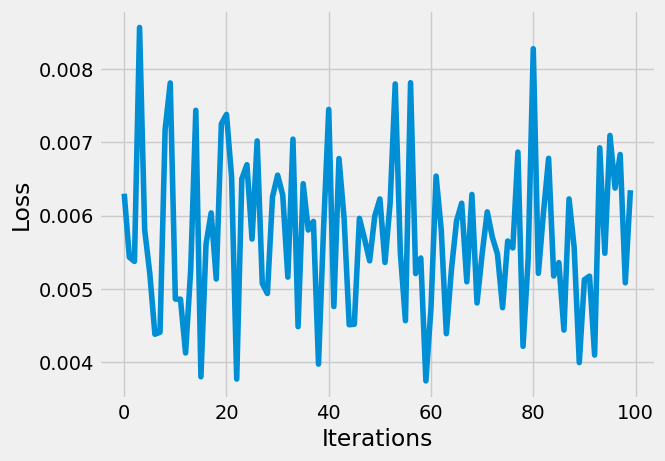

In [7]:
import matplotlib.pyplot as plt

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses[-100:])

We can now use the encoder bit of the autoencoder architecture to obtain the 3 feature projection of our original feature space.

In [8]:
# Result storage
embedded = []
embedded_y = []

# Iterate over all samples
for (X_sample, y_sample) in train:
    embedded.append(
        model.encoder(X_sample).detach().numpy()
    )
    embedded_y.append(y_sample)

# Reshape the result
embedded = np.array(embedded).reshape(569,3)

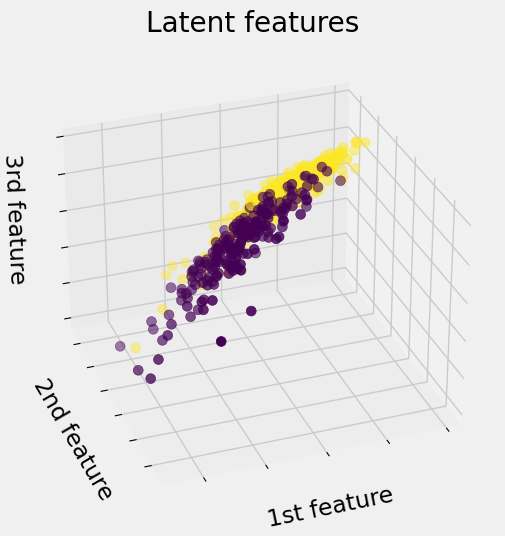

In [9]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

ax.scatter(
    embedded[:, 0],
    embedded[:, 1],
    embedded[:, 2],
    c=embedded_y,
    s=50
)

ax.set_title("Latent features")
ax.set_xlabel("1st feature")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd feature")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd feature")
ax.zaxis.set_ticklabels([])

plt.show()

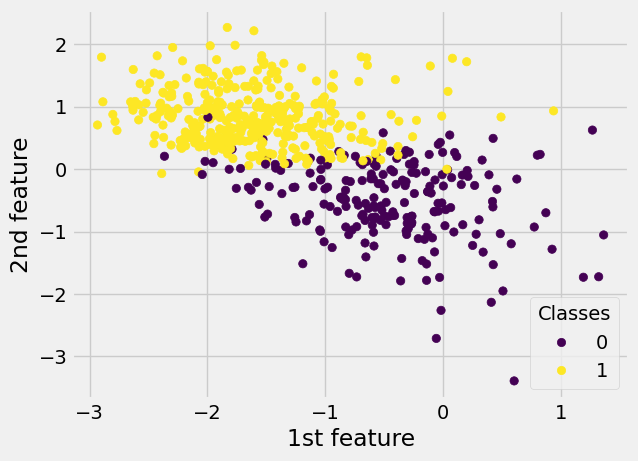

In [10]:
_, ax = plt.subplots()
scatter = ax.scatter(embedded[:, 0], embedded[:, 1], c=Y)
ax.set(xlabel="1st feature", ylabel="2nd feature")
_ = ax.legend(
    scatter.legend_elements()[0], ["0", "1"], loc="lower right", title="Classes"
)

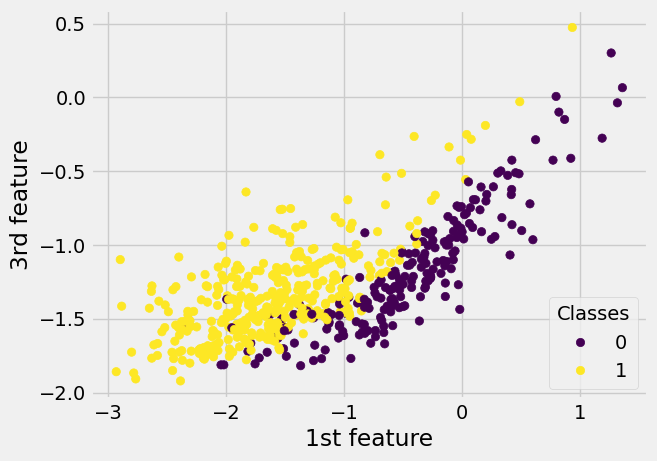

In [11]:
_, ax = plt.subplots()
scatter = ax.scatter(embedded[:, 0], embedded[:, 2], c=Y)
ax.set(xlabel="1st feature", ylabel="3rd feature")
_ = ax.legend(
    scatter.legend_elements()[0], ["0", "1"], loc="lower right", title="Classes"
)

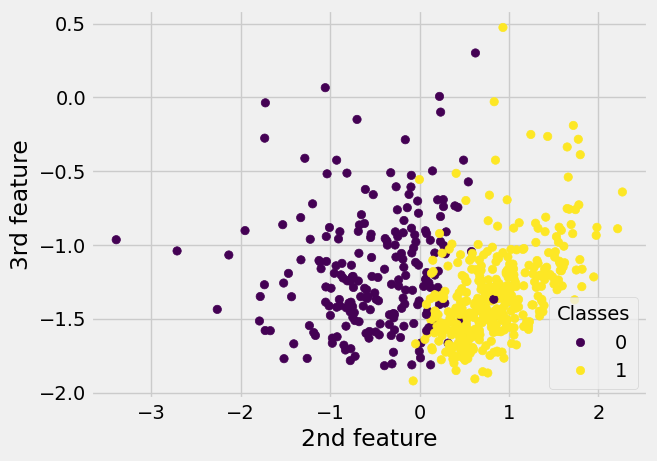

In [12]:
_, ax = plt.subplots()
scatter = ax.scatter(embedded[:, 1], embedded[:, 2], c=Y)
ax.set(xlabel="2nd feature", ylabel="3rd feature")
_ = ax.legend(
    scatter.legend_elements()[0], ["0", "1"], loc="lower right", title="Classes"
)